In [ ]:
# Importing cell

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import warnings

warnings.filterwarnings("ignore")


-----------------------------

# Physical Models of Living Systems

#### *Rafaele Gaudio 2057974*

-----------------------------

## Week 7: - Deadline 19 Dicember 

Calculate the avalanche duration probability $P>(t)$ if $\lambda_i(t) = \lambda(t)$ for all $t$ and all neurons. This leads, as only sketched in class, to the following integral: 
$$
\gamma \int_0^\infty d\lambda(t) \exp(-\gamma\lambda(t))(1-\exp(-\delta\lambda(t)))^n
$$

which can be solved through the saddle point approximation.

Optional. Create a time series $\lambda(t)$, with $t=1,2,...,T$ where at each time $t$, the value of $\lambda$ is extracted from an exponential distribution. Then simulate N=100 independent heterogeneous Poisson processes, where each one describes the spikes events of a single neuron, but all have the same time dependent rate parameter $\lambda(t)$.


-----------------------------

### 1. Avalanche duration probability

In order to compute the avalanche duration probability, we can use the saddle-point strategy:

$$
I(s)= \int_C dx\: g(x) e^{sf(x)} |_{s \rightarrow \infty}\approx \sqrt{\frac{2\pi}{|sf^{''}(x_c)|}}g(x_c)e^{sf(x_c)}
$$

with $x_c$ such that $f^{'}(x_c)=0$.

We can rewrite the integral (omitting the dependence of $\lambda$ from $t$) as:
$$
I(n)=\gamma \int_0^\infty d\lambda \; e^{-\gamma\lambda}  e^ {n\ln(1-e^{-\delta\lambda})}=\gamma \int_0^\infty d\lambda\; e^ {n[\ln(1-e^{-\delta\lambda})-\frac{\gamma\lambda}{n}]}
$$

in this way we identify:
$$
 f(\lambda)=\ln(1-e^{- \delta \lambda})-\frac{\gamma \lambda}{n}
$$

so:

$$
f^{'}(\lambda)= \frac{\delta e^{-\delta\lambda}}{1-e^{-\delta\lambda}}-\frac{\gamma}{n} \quad \rightarrow \quad \lambda_c=-\frac{1}{\delta}\ln\left(\frac{\gamma}{n\delta +\gamma}\right) 
$$
$$
f^{''}(\lambda)= -\frac{\delta^2 e^{-\delta\lambda}}{(1-e^{-\delta\lambda})^2} \le 0
$$

As we can observe, $\lambda_c$ is a maximum of $f(\lambda)$ within the domain $C=[0,\infty)$ that stays far from the boundary, so the saddle-point approximation holds.

After the evaluation of $f(\lambda_c)$ and $f^{''}(\lambda_c)$:

$$
f(\lambda_c)=\ln \left(1- \frac{\gamma}{n\delta +\gamma}\right) + \frac{\gamma}{n\delta} \ln \left( \frac{\gamma}{n\delta +\gamma} \right)
$$

$$
f^{''}(\lambda_c)= -\frac{\delta^2\gamma}{n\delta +\gamma}\left(1- \frac{\gamma}{n\delta +\gamma} \right)^{-2}
$$


we can conclude that, for $n\rightarrow \infty$, the integral is:

$$
I(n) \approx \gamma \sqrt{2\pi \left| -\frac{n\delta +\gamma}{n\delta^2\gamma}\right|}\left( 1- \frac{\gamma}{n\delta +\gamma}\right)^{n+1}\left( \frac{\gamma}{n\delta +\gamma}\right)^{\gamma/\delta}
$$

or in a more compact form:
$$
I(n) \approx \gamma \sqrt{\frac{2\pi}{|-n\delta^2\alpha|}}(1-\alpha)^{n+1}\alpha^{\gamma/\delta} \quad \text{with} \quad \alpha=\frac{\gamma}{n\delta +\gamma}
$$

### 2. Inhomogeneous Poisson  process for 100 neurons (optional point)

In [7]:
# functios cell

def multi_step(points, rep=100):
    new_points = []
    for point in points:
        to_insert = [point]*rep
        new_points = [*new_points, *to_insert]
    return new_points



def lambdas(alpha, num_points, seed):
    np.random.seed(seed)
    lambs = np.random.exponential(scale=alpha, size=num_points)
    return lambs



def thinning(spikes_times, fr, r_max):
    index=[]
    for (i,spike) in zip(range(len(spikes_times)),spikes_times):
        x = np.random.uniform()
        r_ti = fr[int(spike)]
        
        if (r_ti/r_max) < x:
            index.append(i)

    for i in sorted(index, reverse=True):
        del spikes_times[i]


def simulation(lambs, N, T):
    fire_rate = multi_step(lambs)
    r_max = np.max(fire_rate)

    num_events = []
    spikes_times = []
    for t in range(T):
        events = np.random.poisson(lam=r_max)
        num_events = [*num_events, events]
        times = list(np.random.uniform(t, t+1, events))
        spikes_times = [*spikes_times, *times]

    thinning(spikes_times,lambs,r_max)

    return spikes_times

In [8]:
# Params control

T = 100             # time duration
N = 100             # number of neuros
alpha = 2           # exponential scale 
sigma = 30          # sigma of the gaussian filter

r_max: 8.66829267917464


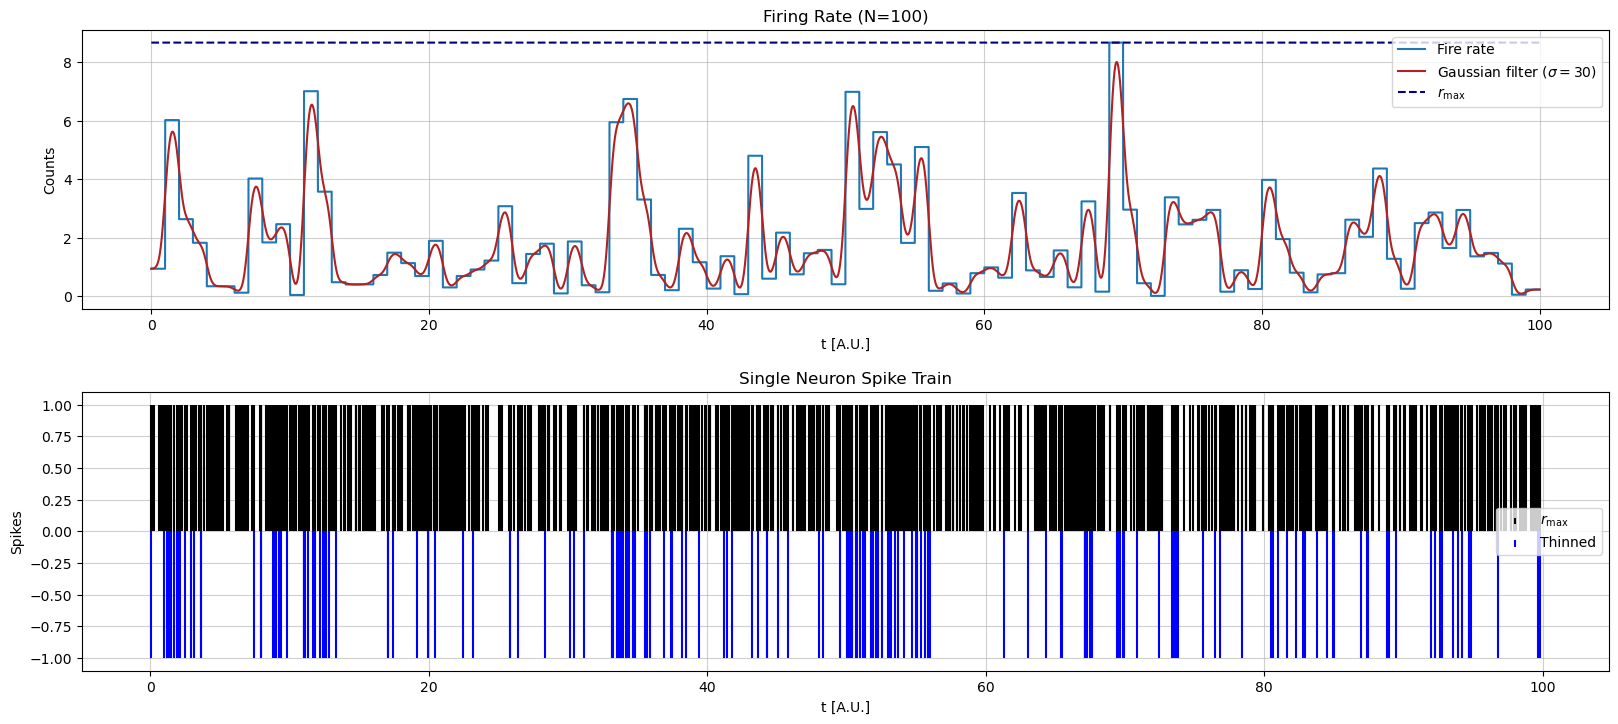

In [9]:
# Single neuron and thinning    

lambs = lambdas(alpha, T, seed=42)
fire_rate = multi_step(lambs)
fire_filtred = gaussian_filter1d(fire_rate, sigma=sigma)

r_max = np.max(fire_rate)
print("r_max:", r_max)

num_events = []
spikes_times = []
for t in range(T):
    events = np.random.poisson(lam=r_max)
    num_events = [*num_events, events]
    times = list(np.random.uniform(t, t+1, events))
    spikes_times = [*spikes_times, *times]

homogeneous_spikes_time = [*spikes_times]
thinning(spikes_times, lambs, r_max)

time = np.linspace(0, T, len(fire_rate))


# Plot

fig, ax = plt.subplots(2,1, figsize=(16,7))
plt.tight_layout()

ax[0].set(xlabel="t [A.U.]", ylabel="Counts",title="Firing Rate (N=100)")
ax[0].plot(time,fire_rate, label="Fire rate")
ax[0].plot(time,fire_filtred,color="firebrick",label="Gaussian filter ($\sigma=${})".format(sigma))
ax[0].plot(time,[r_max]*len(fire_rate),ls="dashed",color="navy",label="$r_{\max}$")
ax[0].legend(loc=1)
ax[0].grid(alpha=0.6)

ax[1].set(xlabel="t [A.U.]", ylabel="Spikes",title="Single Neuron Spike Train")
ax[1].stem(homogeneous_spikes_time,[1]*len(homogeneous_spikes_time),"k" ,markerfmt=" ", basefmt=" ",label="$r_{\max}$")
ax[1].stem(spikes_times,[-1]*len(spikes_times),"b",markerfmt=" ", basefmt=" ",label="Thinned");
ax[1].legend(loc=5)
ax[1].grid(alpha=0.6)

fig.subplots_adjust(hspace=0.3)

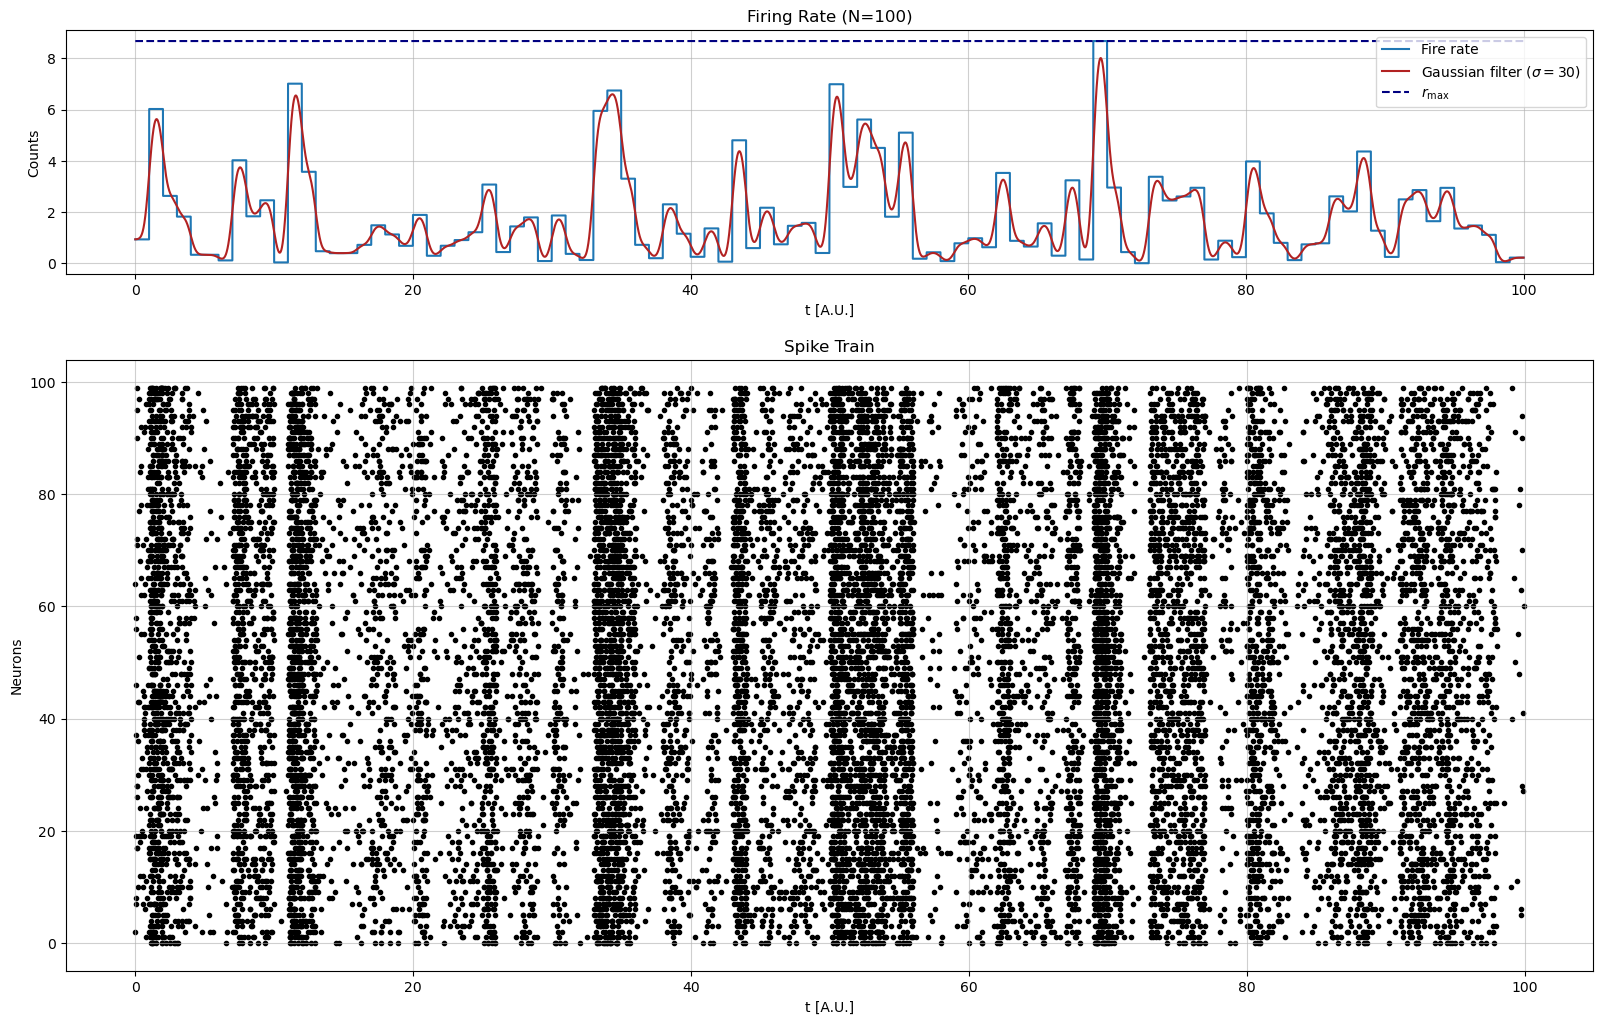

In [10]:
# 100 neurons simulation

sim_results = []
for i in range(N):
    sim = simulation(lambs, N, T)
    sim_results = [*sim_results, sim]


# Plot

fig, ax = plt.subplots(2,1, figsize=(16,10), gridspec_kw={"height_ratios": [1, 2.5]})
plt.tight_layout()

ax[0].set(xlabel="t [A.U.]", ylabel="Counts",title="Firing Rate (N=100)")
ax[0].plot(time,fire_rate, label="Fire rate")
ax[0].plot(time,fire_filtred,ls="-",color="firebrick",label="Gaussian filter ($\sigma=${})".format(sigma))
ax[0].plot(time,[r_max]*len(fire_rate),ls="dashed",color="navy",label="$r_{\max}$")
ax[0].legend(loc=1)
ax[0].grid(alpha=0.6)

ax[1].set(xlabel="t [A.U.]", ylabel="Neurons",title="Spike Train")
for i in range(N):
    ax[1].scatter(sim_results[i], [i]*len(sim_results[i]),color="black", marker=".")
ax[1].grid(alpha=0.6)

fig.subplots_adjust(hspace=0.2)